# Setup

Run the following cell to prepare execution.

In [4]:
import ipywidgets as widgets

def callback(_button):
    import numpy as np
    
button = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
button.on_click(callback)
button



Button(description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

In [3]:
np

NameError: name 'np' is not defined

In [ ]:

import os
import shutil
import torch
import warnings
from pathlib import Path
from tempfile import TemporaryDirectory
from IPython.display import display
from rich.console import Console
from tqdm import tqdm
import numpy as np

from preprocessing import process_dicomdir
from models import FunneledUNet
from dataset import GenericDataset
from postprocessing import case_respect_requirements, find_interesting_slice, with_peritumorale
import nibabel
console = Console()
opts = dict(
    dicom_sources=Path("../fegato/Sync/HUMANITAS/CT SCAN"),
    torch_sources=Path("./fined_data"),
    dicom_results=Path("./postprocessed_data"),
    saved_models=Path("./saved_models"),
    outputs=Path("./outputs"),

    epochs=100,
    batch_size=4,
    validation_percent=0.1,
    learning_rate=1e-3,
    adabelief_eps=1e-8,
    adabelief_b1=0.9,
    adabelief_b2=0.999,
    num_workers=8,
)

In [27]:
import torch
scan = torch.load("../outputs/Hum237/zwindow.pt")["scan"].float()
segm = torch.load("../outputs/Hum237/zwindow.pt")["segmentation"].float()

import seaborn
import seaborn_image
from ipywidgets import interact, interactive, fixed, interact_manual

seaborn.set(rc={'figure.figsize':(10,10)})
# data = torch.clamp(registered[[1, 3, 2], ..., :].permute(2, 1, 0, 3), 0, 255)
#m = min([ originals[phase].size(-1) for phase in ["b", "a", "v", "t"] ])

def scale(x):
    return torch.clamp(
        torch.nn.functional.avg_pool3d(x, (4,4,1)),
        0, 255) / 255

def sscale(x):
    return torch.nn.functional.avg_pool3d(x, (4,4,1)) / 2


def show(z):
    data = torch.stack([
        scale(scan)[2, :, :, z],
        sscale(segm.unsqueeze(0))[0, :, :, z],
        scale(scan)[2, :, :, z],
        #torch.clamp(scan[2, :, :, z], 0, 255) / 255 + segm[:, :, z] / 2,
        #torch.clamp(scan[2, :, :, z], 0, 255) / 255,
    ]).permute(2, 1, 0)
    seaborn_image.imgplot(
        data,
        cbar=False,
    )

interact(show, z=(0, 31))

interactive(children=(IntSlider(value=15, description='z', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(z)>

## Check if nnunet+lifex has screwed up

In [10]:
import nibabel, numpy as np, seaborn, seaborn_image, torch
from pathlib import Path
from torch.nn.functional import max_pool3d, avg_pool3d, one_hot, interpolate
from ipywidgets import interact, interactive, fixed, interact_manual

case = Path("../outputs/Hum268/")
seaborn.set(rc={'figure.figsize':(10,10)})

scan = torch.stack([
    torch.tensor(np.array(nibabel.load(
        case / f"registered_phase_{phase}.nii.gz"
    ).dataobj, dtype=np.int16)).float()
    for phase in ["b", "a", "v", "t"]
]).unsqueeze(0)
segm = one_hot(
    torch.tensor(np.array(nibabel.load(
        case / f"segmentation.nii.gz"
    ).dataobj, dtype=np.int16)).long(),
    3
).permute(3, 0, 1, 2).unsqueeze(0).float()
# segm = torch.zeros(1, 3, 512, 512, scan.size(4))

base = torch.clamp(torch.narrow(
    scan, 
    dim=1,
    start=2,  # Phase 2 = V
    length=1
), 0, 256) / 256

red = base
green = torch.clamp(base + torch.narrow(
    segm, 
    dim=1,
    start=2,  # Class 2 = Tumor
    length=1
), 0, 1)
blue = torch.clamp(base + torch.narrow(
    segm, 
    dim=1,
    start=1,  # Class 2 = Liver
    length=1
), 0, 1)
    

def show(z):
    data = torch.stack([
        red[0, 0, ..., z],
        green[0, 0, ..., z],
        blue[0, 0, ..., z],
    ]).permute(2, 1, 0)
    seaborn_image.imgplot(
        data,
        cbar=False,
    )

interact(show, z=(0, scan.size(4)-1))

interactive(children=(IntSlider(value=99, description='z', max=198), Output()), _dom_classes=('widget-interact…

<function __main__.show(z)>

## Reaffine registered images


In [ ]:
from pathlib import Path
from torch.nn.functional import max_pool3d, avg_pool3d, one_hot, interpolate
from ipywidgets import interact, interactive, fixed, interact_manual

case = Path("../outputs/Hum260/")

for phase in ["b", "a", "v", "t"]:
    image = nibabel.load(case / f"registered_phase_{phase}.nii.gz")
    nibabel.save(
        nibabel.Nifti1Image(
            image.dataobj,
            affine=np.array([[-1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 5.0, 0], [0, 0,  0, 1]], dtype=float)
        ),
        case / f"registered_phase_{phase}.nii.gz",
    )
    

## Flip sagittal

In [8]:
from pathlib import Path
from torch.nn.functional import max_pool3d, avg_pool3d, one_hot, interpolate
from ipywidgets import interact, interactive, fixed, interact_manual

case = Path("../outputs/Hum263/")

image = nibabel.load(case / f"segmentation.nii.gz")
nibabel.save(
    nibabel.Nifti1Image(
        np.flip(np.array(image.dataobj), axis=1),
        affine=image.affine @ np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0,  0, 1]])
    ),
    case / f"segmentation.nii.gz",
)

## Check predictions

In [4]:
from pathlib import Path
import  nibabel, numpy as np, torch, seaborn, seaborn_image
from torch.nn.functional import max_pool3d, avg_pool3d, one_hot, interpolate
from ipywidgets import interact, interactive, fixed, interact_manual

import models
from path_explorer import discover, get_criterion

seaborn.set(rc={'figure.figsize':(10,10)})
base_path = Path("../outputs/")
cases = discover(base_path, get_criterion(registered=True, segmented=True))

scan, segm, dgpred = None, None, None

@torch.no_grad()
def generate(case, model882):
    global scan, segm, dgpred
    case = base_path / case
    scan = torch.stack([
            torch.tensor(np.array(nibabel.load(
                case / f"registered_phase_{phase}.nii.gz"
            ).dataobj, dtype=np.int16)).float()
            for phase in ["b", "a", "v", "t"]
        ]).unsqueeze(0)
    segm = one_hot(
            torch.tensor(np.array(nibabel.load(
                case / f"segmentation.nii.gz"
            ).dataobj, dtype=np.int16)).long(),
            3
        ).permute(3, 0, 1, 2).unsqueeze(0).float()
    
    net882 = models.get_model(model=model882, saved_models=Path("saved_models")).to(device=torch.device("cpu"), dtype=torch.float32)
    dgscan = avg_pool3d(
        scan,
        kernel_size=(8, 8, 2)
    )
    dgpred = interpolate(net882(dgscan), scan.shape[2:5], mode="trilinear")

interact(
    generate,
    case=cases,
    model882=["segm882.7", "segm882.2", "segm882.3", "segm882.4", "segm882.5", "segm882.6", "segm882.8"],
)
pass

interactive(children=(Dropdown(description='case', options=(PosixPath('Hum185'), PosixPath('Hum253'), PosixPat…

In [5]:
def show(on_white, on_green, on_blue, z):
    if on_white=="basale":
        white = torch.clamp(scan[:, 0:1, :, :, :], 0, 256) / 256
    elif on_white=="arteriosa":
        white = torch.clamp(scan[:, 1:2, :, :, :], 0, 256) / 256
    elif on_white=="venosa":
        white = torch.clamp(scan[:, 2:3, :, :, :], 0, 256) / 256
    elif on_white=="tardiva":
        white = torch.clamp(scan[:, 3:4, :, :, :], 0, 256) / 256

    red = white
    
    if on_green=="dgpred_liver":
        green = torch.clamp(white + dgpred[:, 1:2, :, :, :], 0, 1)
    elif on_green=="dgpred_tumor":
        green = torch.clamp(white + dgpred[:, 2:3, :, :, :], 0, 1)
    else:
        green = white
    
    if on_blue=="segm_liver":
        blue = torch.clamp(white + segm[:, 1:2, :, :, :], 0, 1)
    elif on_blue=="segm_tumor":
        blue = torch.clamp(white + segm[:, 2:3, :, :, :], 0, 1)
    else:
        blue = white
    
    z = min(z, scan.size(4)-1)
    data = torch.stack([
        red[0, 0, :, :, z],
        green[0, 0, :, :, z],
        blue[0, 0, :, :, z],
    ]).permute(2, 1, 0)
    seaborn_image.imgplot(
        data,
        cbar=False,
    )

interact(
    show,
    on_white=["basale", "arteriosa", "venosa", "tardiva"],
    on_green=["none", "dgpred_liver", "dgpred_tumor"],
    on_blue=["none", "segm_liver", "segm_tumor"],
    z = (0, 200),
)

interactive(children=(Dropdown(description='on_white', options=('basale', 'arteriosa', 'venosa', 'tardiva'), v…

<function __main__.show(on_white, on_green, on_blue, z)>

## Pretraining

In [2]:
from segm.train import defaults as opts, torch, console, FunneledUNet, samples, Iterator, Tensor, BufferDataset, scan_segm_tuples, F
import models
import seaborn
import seaborn_image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
console.print(f'Using device {device}')

seaborn.set(rc={'figure.figsize':(10,10)})

net = FunneledUNet(
    channels=[7, 16, 32, 48, 64],
    wafer_size=opts["wafer_size"],
    final_classes=3,
).to(device=device, dtype=torch.float32)

net882 = models.get_model(**dict(opts, model="segm882.7")).to(device=torch.device("cpu"), dtype=torch.float32)
net882.eval()

def get_wafer() -> Iterator[Tensor]:
    for (scan, segm) in scan_segm_tuples(opts["outputs"]):
        dgscan = F.avg_pool3d(
            scan,
            kernel_size=(8, 8, 2)
        )

        with torch.no_grad():
            dgpred = net882(dgscan)

        whole = torch.cat([
            scan,
            F.interpolate(dgpred, scan.shape[2:5], mode="trilinear"),
            segm,
        ], dim=1)
        for z in range(1 + scan.size(4) - opts["wafer_size"]):
            yield whole[..., z:z + opts["wafer_size"]]

with torch.no_grad():
    dataset = BufferDataset(
        tensor_generator=get_wafer(),
        buffer_size=41,
    )
    

torch.Size([512, 512, 3])


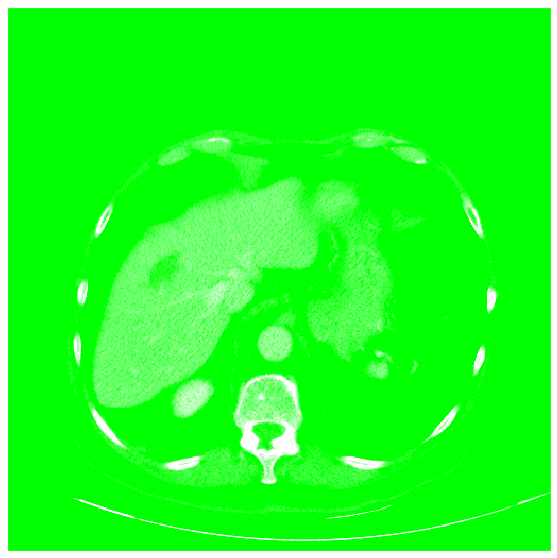

In [55]:
with torch.no_grad():    
    data = samples(net, dataset, device, mode=("pred_background", "pred_tumor", "pred_liver"), indices=[30]).squeeze().cpu().permute(2, 1, 0)
    print(data.shape)
    seaborn_image.imgplot(
        data,
        cbar=False,
    )

In [155]:
for t in net.parameters():
    print(t.shape)
    if t.dim() == 4 and t.size(3) == 3:
        torch.nn.init.normal_(t, mean=0.0, std=0.001)
        torch.nn.init.eye_(t[:, :, 1, 1])
    elif t.dim() == 4 and t.size(3) == 1:
        # torch.nn.init.normal_(t, mean=0.0, std=0.001)
        torch.nn.init.eye_(t[:, :, 0, 0])
    elif t.dim() == 1:
        torch.nn.init.normal_(t, mean=0.0, std=0.001)
net

torch.Size([16, 7, 5, 5, 5])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([48, 32, 3, 3])
torch.Size([48])
torch.Size([48, 48, 3, 3])
torch.Size([48])
torch.Size([64, 48, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([48, 112, 3, 3])
torch.Size([48])
torch.Size([48, 48, 3, 3])
torch.Size([48])
torch.Size([32, 80, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([3, 32, 1, 1])
torch.Size([3])


FunneledUNet(
  (funnel): Funnel(
    (pad): ConstantPad3d(padding=(0, 0, 2, 2, 2, 2), value=0.0)
    (conv): Conv3d(7, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  )
  (body): UNetLayer(
    (block): Block(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (submodule): UNetLayer(
      (block): Block(
        (model): Sequential(
          (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=True)
          (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (submodule): UNetLayer(
        (block): Block(
          (m

In [152]:
w = torch.zeros(16, 7, 5, 5, 5)
w[0, 4, 2, 2, 2] = 1
w[1, 5, 2, 2, 2] = 1
w[2, 6, 2, 2, 2] = 1
net.funnel.conv.weight = torch.nn.Parameter(w)
net.to(device=device, dtype=torch.float32)
pass

torch.Size([1, 7, 512, 512, 5])
torch.Size([1, 16, 512, 512])
tensor(-0.0019, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0009, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 512, 512])
tensor(-0.0089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0041, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 512, 512])
tensor(0.1926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.5769, device='cuda:0', grad_fn=<MaxBackward1>)


<AxesSubplot:>

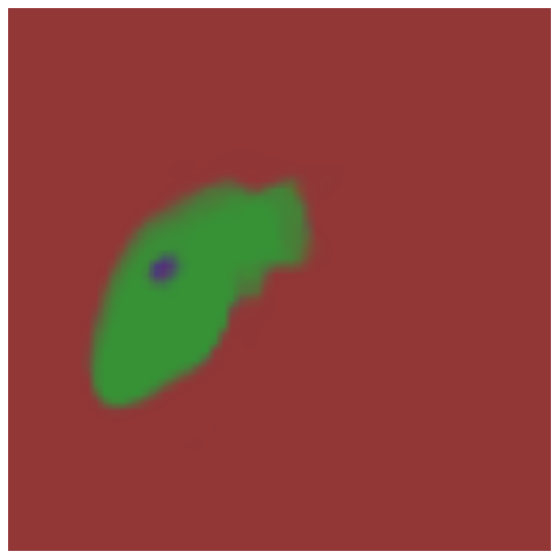

In [153]:
data = dataset[30][:, 0:7].to(device=device, dtype=torch.float32)
print(data.shape)
data = net.funnel(data)
print(data.shape)
print(torch.min(data))
print(torch.max(data))
data = net.body(data)
print(data.shape)
print(torch.min(data))
print(torch.max(data))
data = net.head(data)
print(data.shape)
print(torch.min(data))
print(torch.max(data))

seaborn_image.imgplot(
        data[0, :].permute(2, 1, 0).detach().cpu(),
        cbar=False,
    )